<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 1  </H3>
<hr style="height:2px;border:none"/>
<H3 align='center'> Jorge Contreras Cabrera 201573547-6  </H3>

<H3 align='center'> César Quiroz Mansilla 201573578-6   </H3>




In [1]:
#Todas las librerias necesarias para realizar la tarea.
import pandas as pd#Trabajar data frame
import numpy as np #Trabajar con matrices
import pylab as pl #Graficos

<a id="primero"></a>
## 1. Aprendizaje con regresión lineal.

El modelo de regresión lineal  es una combinación lineal entre variables independientes para obtener otra variable, dependiente de éstas. Lo cual puede resultar bastante simple, pero, hoy en día, ha podido ser aplicado a varios problemas con buenos resultados, como predicción en finanzas y en medicina. Sin embargo, también puede ser un medio para aplicar un modelo más grande, por ejemplo utilizarlo para que, con el resuido, detectar *outliers*, rellenar vacíos/datos incompletos o aprender un *score* para ranquear objetos, lo que haremos en esta sección.

<img src="http://chanakya.ca/wp-content/uploads/2018/05/EstimateMultipleLinearRegressionCoefficientsExample_01.png" height="15%" />


El problema de *learning to rank* es aplicado comúnmente en *Information Retrieval* (IR). Sin embargo, el aprender ésta función puede ser crucial para modelar la importancia de distintos objetos.  


En esta actividad trabajaremos con el problema de predecir el *ranking* mundial de una Universidad en base a distintas características de ésta (dataset *World University Rankings*, a través del siguiente __[link](https://www.kaggle.com/mylesoneill/world-university-rankings)__) en la plataforma de *Kaggle*. En este problema el *ranking* es una medición de qué tan buena es la universidad e intentaremos predecirla a través un modelo simple de regresión lineal. En particular, dentro de los miles de diferentes sistemas de rankings, nacionales e internacionales, entre los cuales comúnmente existen desacuerdos entre ellos, trabajaremos con el ranking ampliamente considerado como uno de las más influyentes y ampliamente observadas: *Times Higher Education World University* .

> a) Cargue los datos a analizar, descargándolos desde la plataforma como se indicó, en formato *dataframe pandas*. Descríbalos adecuadamente, ya sea la variable dependiente o las independientes, si es que lo son.

In [2]:
df = pd.read_csv("world-university-rankings/timesData.csv")
df.columns.values.tolist()

['world_rank',
 'university_name',
 'country',
 'teaching',
 'international',
 'research',
 'citations',
 'income',
 'total_score',
 'num_students',
 'student_staff_ratio',
 'international_students',
 'female_male_ratio',
 'year']

+ university name
+ year

Variables independientes:
+ country
+ teaching
+ international
+ research
+ citations
+ income
+ student staff ratio
+ international students
+ female male ratio

Variables dependientes:
+ world rank
+ total score

> b) Debido a la estructura será necesario realizar un leve pre-proceso. Existen vacíos entre los datos o valores '-', por lo que será necesario eliminarlos (*o si piensa una mejor manera de manejar ésto puede hacerlo, se verá reflejado en su nota*). Además de ésto deje los datos con *score unkown* o '-' en un conjunto *target* separado, *unlabeled data* (éste será el objetivo del entrenamiento) ¿Cuántos datos quedan en cada conjunto? 

In [3]:
def convertToInt(x):
    try:
        x = int(x)
    except:
        x = 0
    return x
df.dropna(axis=0,inplace=True,how='any') #borra nan
df["total_score"] = df["total_score"].apply(lambda x: x.replace('-','unknown')) #rellena 
df = df[~(df == '-').any(axis=1)] #elimina filas con valores nulos

nuevo_df  = pd.get_dummies(df, columns=["country"]) #column to categorical

nuevo_df['female'] = nuevo_df['female_male_ratio'].str.split(':', expand=True)[0].apply(convertToInt)
nuevo_df['male'] = nuevo_df['female_male_ratio'].str.split(':', expand=True)[1].apply(convertToInt)
nuevo_df['female_male_ratio'] =  np.where(nuevo_df['male'] == 0, 0, nuevo_df['female']/nuevo_df['male']) #si no hay (rellena 0) 
nuevo_df['num_students'] = nuevo_df['num_students'].apply(lambda x: int(str(x).replace(',','')))
nuevo_df['international_students'] = nuevo_df['international_students'].apply(lambda x: int(str(x).replace('%','')))
df_test = nuevo_df[nuevo_df["total_score"]=='unknown']  #para predecir al final
nuevo_df =  nuevo_df[nuevo_df["total_score"]!='unknown'] #elimina unknown rank..
print("Dimensiones de test",df_test.shape)
print("Dimensiones de train",nuevo_df.shape)

Dimensiones de test (1220, 82)
Dimensiones de train (954, 82)


+ tanto el archivo de entrenamiento y test deben contener la misma cantidad de columnas (82)

> c) Cree las matrices de cada conjunto con las que trabajará. Además de ésto separe el conjunto de pruebas fijo que se utilizará, recuerde que éste no puede ser utilizado. Si estima conveniente también cree conjunto de validación.

In [4]:
Y = nuevo_df['total_score'].values  #Variable de salida
X = nuevo_df.drop(["total_score","world_rank","university_name"],axis=1).values #Variable de entrada
X_test = df_test.drop(["total_score","world_rank","university_name"],axis=1).values #Variables de entrada para test
Y = Y.astype('float32') #transforma valores en float
X = X.astype('float32')
X_test = X_test.astype('float32')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42) #crea los conjuntos

> d) Normalice los datos antes de trabajar. Explique la importancia/conveniencia de realizar ésto.

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

> e) Realice una regresión lineal de mı́nimos cuadrados básica. Mida el residuo de cada predicción en cada dato y haga un gráfico de éste ¿Qué indica lo observado?

/Users/marcelacamilaosoriofarias/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


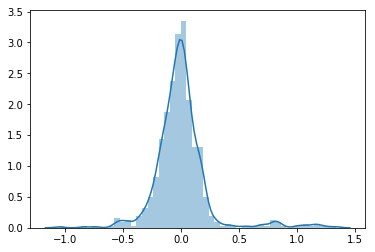

In [28]:
from sklearn.linear_model import LinearRegression as LR
linreg = LR(fit_intercept=True, n_jobs=1)
linreg.fit(X_train_scaled,y_train)

import seaborn as sns
res = y_train-linreg.predict(X_train_scaled)
sns.distplot(res)

> f) Construya una tabla con los pesos, Z-score y F-score correspondientes a cada predictor (variable), compare estos valores. ¿Qué sucede si hacemos un raking de los atributos en base al peso obtenido en la regresión? Compare y comente ¿Qué variables están más correlacionadas con la respuesta? Si usáramos un nivel de significación del 5%. ¿Qué es lo que observa y cuál puede ser la causa?

In [9]:
from scipy import stats

#Z-score
y_pro=y_test.mean()
#Calculo sigma cuadrado
y_pred=linreg.predict(X_test_scaled)
sigma=y_test-y_pred
va=np.var(sigma)
#calculos promedios x_i
promedios=[]
v=0
while v < len(X_train_scaled[0]):
    i=0
    suma=0
    while  i< len(X_train_scaled):
        suma=X_train_scaled[i][v]+suma
        i=i+1
    p=suma/len(X_train_scaled)
    promedios.append(p)
    v=v+1
#Calculo de la raiz  
v=0
constante=[]
while v < len(X_train_scaled[0]):
    i=0
    cons=0
    while  i< len(X_train_scaled):
        cons=((X_train_scaled[i][v]-promedios[v])**2)
        i=i+1
    constante.append(cons)
    v=v+1
v=0
#Calculo z-score
z_score=[]
while v < len(X_train_scaled[0]):
    i=0
    score=0
    while  i< len(X_train_scaled):
        score=(X_train_scaled[i][v]-promedios[v])*(y_test[v]-y_pro)/constante[v]
        i=i+1
    z_score.append(score*va)
    v=v+1 
    
#F-score
ssr=(y_test-y_pro)**2
sse=(y_test-y_pred)**2
sst=ssr+sse
p_2=ssr/sst
n=len(p_2)
f_score=(n-2)*p_2/(1-p_2)

/Users/marcelacamilaosoriofarias/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/Users/marcelacamilaosoriofarias/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide


> g) Calcule la información mútua de los distintos predictores (variables) con respecto a la variable *output* o *target*. Comente con lo calculado anteriormente y se le parece razonable.

In [11]:
from sklearn.feature_selection import mutual_info_regression
minfo_predictor = mutual_info_regression(X,Y)


> h)  Construya una función que implemente *Forward Step-wise Selection* (FSS). Es decir, partiendo con un modelo sin predictores (variables), agregue un predictor a la vez, re-ajustando el modelo de regresión en cada paso. Para seleccionar localmente una variable, proponga/implemente un criterio distinto al utilizado en el código de ejemplo. Construya un gráfico que muestre el error de entrenamiento y el error de pruebas como función del número de variables en el modelo. Ordene el eje $x$ de menor a mayor.

In [14]:

def fss(x, y, names_x, k = 10000):
    p = x.shape[1]-1
    k = min(p, k)
    names_x = np.array(names_x)
    remaining = list(range(0, p))
    selected = [p]
    current_score = best_new_score = 0.0
    while remaining and len(selected)<=k :
        score_candidates = []
        for candidate in remaining:
            model = LR(fit_intercept=True, n_jobs=1)
            indexes = selected + [candidate]
            x_train = x[:,indexes]
            predictions_train = model.fit(x_train, y).predict(x_train)
            residuals_train = predictions_train - y
            mse_candidate = np.mean(np.power(residuals_train, 2))
            score_candidates.append((mse_candidate, candidate))
        score_candidates.sort()
        score_candidates[:] = score_candidates[::-1]
        best_new_score, best_candidate = score_candidates.pop()
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        print ("selected = %s ..."%names_x[best_candidate])
        print ("totalvars=%d, mse = %f"%(len(indexes),best_new_score))
    return selected
names_regressors = nuevo_df.drop(["total_score","world_rank","university_name"],axis=1).columns
fss(X_train_scaled,y_train,names_regressors)

selected = teaching ...
totalvars=2, mse = 27.585627
selected = citations ...
totalvars=3, mse = 10.429185
selected = research ...
totalvars=4, mse = 2.441643
selected = international ...
totalvars=5, mse = 0.315024
selected = income ...
totalvars=6, mse = 0.069449
selected = country_Egypt ...
totalvars=7, mse = 0.064533
selected = year ...
totalvars=8, mse = 0.061104
selected = country_United States of America ...
totalvars=9, mse = 0.059326
selected = num_students ...
totalvars=10, mse = 0.058948
selected = country_Spain ...
totalvars=11, mse = 0.058592
selected = country_France ...
totalvars=12, mse = 0.058370
selected = international_students ...
totalvars=13, mse = 0.058097
selected = country_New Zealand ...
totalvars=14, mse = 0.057909
selected = country_Turkey ...
totalvars=15, mse = 0.057762
selected = country_China ...
totalvars=16, mse = 0.057651
selected = country_Japan ...
totalvars=17, mse = 0.057570
selected = country_Italy ...
totalvars=18, mse = 0.057480
selected = coun

[78,
 0,
 3,
 2,
 1,
 4,
 23,
 9,
 76,
 5,
 66,
 26,
 7,
 48,
 71,
 18,
 37,
 36,
 14,
 47,
 65,
 69,
 27,
 42,
 67,
 8,
 11,
 58,
 29,
 15,
 61,
 35,
 12,
 50,
 22,
 6,
 56,
 16,
 25,
 64,
 75,
 10,
 13,
 17,
 19,
 20,
 77,
 21,
 24,
 28,
 30,
 31,
 32,
 33,
 34,
 38,
 39,
 40,
 41,
 43,
 44,
 45,
 46,
 49,
 51,
 68,
 52,
 53,
 54,
 55,
 57,
 59,
 60,
 62,
 63,
 70,
 72,
 73,
 74]

> i) Ajuste un modelo lineal utilizando “*Ridge Regression*”, es decir, regularizando con la norma $l_2$. Utilice valores del parámetro de regularización $\lambda$ en el rango [$10^0, 10^6$], variando si estima conveniente. Construya un gráfico que muestre los coeficientes obtenidos como función del parámetro de regularización. Deje un gráfico sólo para analizar los coeficientes de los países. Describa lo que observa.

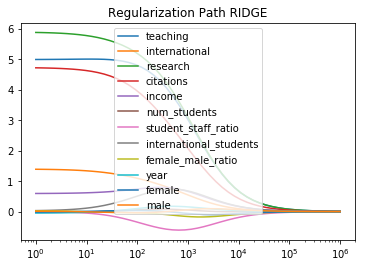

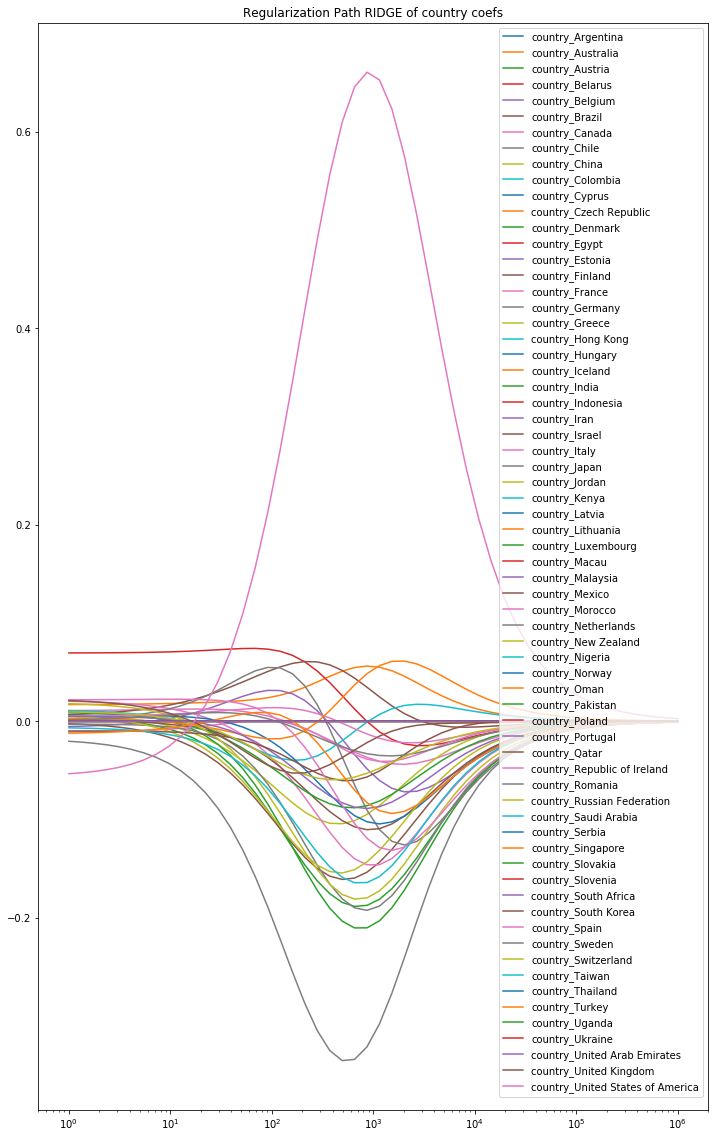

In [25]:
from sklearn.linear_model import Ridge
import matplotlib.pylab as plt
names_regressors = nuevo_df.drop(["total_score","world_rank","university_name"],axis=1).columns
alphas_ = np.logspace(0,6,base=10)
coefs = []
model = Ridge(fit_intercept=True,solver='svd')
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(X_train_scaled, y_train)
    coefs.append(model.coef_)
ax = plt.gca()
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    if "country" not in label:
        plt.plot(alphas_, y_arr, label=label)
ax.set_xscale('log')
plt.title('Regularization Path RIDGE')
plt.legend()
plt.show()

plt.figure(figsize=(12, 20))
ax = plt.gca()
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    if "country" in label:
        plt.plot(alphas_, y_arr, label=label)
ax.set_xscale('log')
plt.title('Regularization Path RIDGE of country coefs')
plt.legend()
plt.show()


> j) Ajuste un modelo lineal utilizando el método “*Lasso*”, es decir, regularizando con la norma $l_1$. Utilice valores del parámetro de regularización $\lambda$ en el rango [$10^{-2},10^3$]. Para obtener el código, modifique el ejemplo anterior. Construya un gráfico que muestre los coeficientes obtenidos como función del parámetro de regularización. Describa lo que observa. ¿Es más efectivo *Lasso* para seleccionar atributos?

In [26]:
from sklearn.linear_model import Lasso
alphas_ = np.logspace(-2,3,base=10)
model = Lasso(fit_intercept=True)


####
country_alphas_ = np.logspace(-5,0,base=10)

> k) Escogiendo uno de los dos métodos regularizadores anteriores, especificando el porqué, construya un gráfico que muestre el error de entrenamiento y el de pruebas como función del parámetro de regularización. Discuta lo que  observa.

In [ ]:
alphas_ = #choose it
coefs = []
model = #choose it
mse_test = []
mse_train = []
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(X_train_scaled, y_train)
    yhat_train = model.predict(X_train_scaled)
    yhat_test = model.predict(X_test_scaled)
    mse_train.append(np.mean(np.power(yhat_train - y_train, 2)))
    mse_test.append(np.mean(np.power(yhat_test - y_test, 2)))
ax = plt.gca()
ax.plot(alphas_,mse_train,label='train error ridge/lasso')
ax.plot(alphas_,mse_test,label='test error ridge/lasso')
plt.legend(loc=1)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.show()

> l) Estime el valor del parámetro de regularización en **alguno** de los modelos anteriores haciendo uso de la técnica validación cruzada con un número de folds igual a $K= 5$ y $K = 10$. Recuerde que para que la estimación sea razonable, en cada configuración (*fold*) deberá reajustar los pesos del modelo. Mida el error real del modelo (ésto es sobre el conjunto de pruebas). Debido a la escala del error puede utilizar auxiliarmente *MAE* como métrica de desempeño. Compare y concluya.

In [ ]:
yhat_test = linreg.predict(X_test_scaled)
mse_test = np.mean(np.power(yhat_test - y_test, 2))
from sklearn.model_selection import KFold
K=10
kf = KFold(n_splits=K)
mse_cv = 0
for train, val in kf.split(X_train_scaled):
    linreg = LR(fit_intercept=True, n_jobs=1)
    linreg.fit(X_train_scaled[train], y_train[train])
    yhat_kfold_val = linreg.predict(X_train_scaled[val])
    mse_fold = np.mean(np.power(yhat_kfold_val - y_train[val], 2))
    mse_cv += mse_fold
mse_cv = mse_cv / K
...#or MAE
mae_fold = np.mean(np.abs(yhat_kfold_val - y_train[val]))

> m) Con el modelo que se piense que es el mejor, en base a todo lo experimentado. Realice el *ranking* de las universidades del que no se tienen etiquetas (*unlabeled data* o *target data*) a través de predecir los datos que se dejaron como *pruebas* y ordenar su score en el *dataframe*.

In [ ]:
df_test["total_score"] = model.predict(X_test_scaled) #predict score
...#armar un raking
univ_chilenas = df_test[df_test["country_Chile"]==1]
rannking_univ_ch = univ_chilenas.sort_values(by="total_score",ascending=False)
ranking = 1
for index,row in rannking_univ_ch.iterrows():
    print("%d - Institucion: %s" %(ranking,row["university_name"]))
    ranking+=1

## 2. Análisis de audios como datos brutos

Distintos tipos de datos han sido tratados en el área de Machine Learning, donde el análisis de estos y
el manejo para poder dejarlos en una representación que se pueda entregar como entrada (al algoritmo) es
crucial. El manejo sobre los datos brutos se denomina pre-procesamiento y existen distintos dependiento del
tipo de datos y los distintos dominios de problemas, tales como imágenes, audios, texto. 


En esta actividad se trabajará con datos de audios los cuales son directamente extraı́dos desde datos fuentes
*.wav*, lo que corresponde a una señal de sonido en diferentes tiempos.

<img src="https://cdn.shopify.com/s/files/1/0977/4240/products/il_fullxfull.1054777221_nym4.jpg?v=1527718941" width="40%" />



El *dataset* se denomina **Heartbeat Sounds** y es presentado en la plataforma Kaggle a través del siguiente  __[link](https://www.kaggle.com/kinguistics/heartbeat-sounds)__. Este dataset consta de grabaciones de sonidos de latidos cardı́acos normales y anormales, con distintas categorı́as para los latidos anormales. 

Para la tarea se trabajará con el *dataset A* presente en la data, el cual corresponde a datos generados desde la vı́a pública mediante la aplicación de Iphone iStethoscope Pro. El objetivo será el de clasificar cada sonido como latido cardı́aco normal o una de las las subcategorı́as de anormal (*Murmur, Extra Heart Sound, Artifact*), por lo que se trata de un problema de clasificación múltiple con 4 clases. Las distintas clasificaciones para los sonidos son explicadas en el sitio de Kaggle.

Para leer y trabajar los archivos de extensión *.wav* se utilizará el siguiente código:

In [4]:
from scipy.io import wavfile
def clean_filename(fname, string): #Borra el "set_a/".
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':
        file_name = string + file_name
    return file_name

SAMPLE_RATE = 44100
def load_wav_file(name, path): #Abrir archivo de sonido.
    s, b = wavfile.read(path + name)
    assert s == SAMPLE_RATE
    return b

> a) Construya un dataframe con los datos a analizar. Describa el dataset y determine cuántos registros hay
por clase.

In [2]:
#Abrr el archivo.csv
import pandas as pd
import numpy as np
df = pd.read_csv('./heartbeat-sounds/set_a.csv')

In [5]:
#Creacion data frame
sonidos=[]
etiquetas=[]
fname=[]
for x in df["fname"]:
    a=" "
    t=clean_filename(x,a)
    if t[0]=="a":  
        y=load_wav_file(t,"./heartbeat-sounds/set_a/")
        sonidos.append(y)
        etiquetas.append("artifact")
        fname.append(x)
    elif t[0]=="n":
        y=load_wav_file(t,"./heartbeat-sounds/set_a/")
        sonidos.append(y)
        etiquetas.append("normal")
        fname.append(x)
    elif t[0]=="e":
        y=load_wav_file(t,"./heartbeat-sounds/set_a/")
        sonidos.append(y)
        etiquetas.append("extrahls")
        fname.append(x)
    elif t[0]=="A":
        y=load_wav_file(t,"./heartbeat-sounds/set_a/")
        sonidos.append(y)
        etiquetas.append("Aunlabelledtest")
        fname.append(x)
    elif t[0]=="m":
        y=load_wav_file(t,"./heartbeat-sounds/set_a/")
        sonidos.append(y)
        etiquetas.append("murmur")
        fname.append(x)
data=pd.DataFrame({
    "Etiqueta" : etiquetas ,
    "Vector" : sonidos,
    "fname" : fname
})
print("Registro por clase (fila,columnas)=",data.shape)
data.head()

Registro por clase (fila,columnas)= (124, 3)


,Etiqueta,Vector,fname
0,artifact,"[1, -3, -1, -7, -9, -2, -6, -5, -3, 4, 2, 4, 2...",set_a/artifact__201012172012.wav
1,artifact,"[-2, 3, -4, 4, -3, 2, -1, 0, 0, 0, 0, 0, 0, -1...",set_a/artifact__201105040918.wav
2,artifact,"[6, -4, -9, -1, -4, 1, -5, 2, 4, 3, 4, 5, 6, -...",set_a/artifact__201105041959.wav
3,artifact,"[-85, -198, -214, -173, -177, -206, -256, -274...",set_a/artifact__201105051017.wav
4,artifact,"[53, -35, 47, 170, 340, 436, 535, 639, 647, 56...",set_a/artifact__201105060108.wav


+ Etiqueta: Corresponde a los distintos tipos de sonido cardiaco.
>+ extrahls (Extra Heart Sound)
>+ Artifact
>+ Murmur
>+ Normal 
+ Vector: Vector numerico de cada audio.wav.
+ fname: Nombre de cada archivo.

El dataframe contiene 124 filas y 3 columnas.

> b) Lea los archivos *.wav* y transformelos en secuencias de tiempo. Realice un *padding* de ceros al final de cada secuencia para que todas queden representadas con la misma cantidad de elementos, explique la importancia de realizar este paso.

In [6]:
def padd_zeros(array,length):
    aux = np.zeros(length)
    aux[:array.shape[0]] = array
    return aux
new_df =pd.DataFrame({'file_name' : data['fname'].apply(clean_filename,string='Aunlabelled'),"target": etiquetas})
new_df['time_series'] = new_df['file_name'].apply(load_wav_file, path ="./heartbeat-sounds/set_a/")
new_df['len_series'] = new_df['time_series'].apply(len) #Antes de rellenar con 0
new_df['time_series']=new_df['time_series'].apply(padd_zeros,length=max(new_df['len_series']))
new_df['len_series'] = new_df['time_series'].apply(len) #Despues de rellenar con 0
new_df.head()

,file_name,target,time_series,len_series
0,artifact__201012172012.wav,artifact,"[1.0, -3.0, -1.0, -7.0, -9.0, -2.0, -6.0, -5.0...",396900
1,artifact__201105040918.wav,artifact,"[-2.0, 3.0, -4.0, 4.0, -3.0, 2.0, -1.0, 0.0, 0...",396900
2,artifact__201105041959.wav,artifact,"[6.0, -4.0, -9.0, -1.0, -4.0, 1.0, -5.0, 2.0, ...",396900
3,artifact__201105051017.wav,artifact,"[-85.0, -198.0, -214.0, -173.0, -177.0, -206.0...",396900
4,artifact__201105060108.wav,artifact,"[53.0, -35.0, 47.0, 170.0, 340.0, 436.0, 535.0...",396900


Es importante que por cada archivo su "time_series" tengan el mismo largo, debido que es un requisito para poder realizar todos los modelos de manera correcta

> c) Manipule los datos y cambie las etiquetas de los audios por otras asignadas por un doctor experto [[4]](#refs), el cual afirma que estos cambios son requeridos. Vuelva a determinar cuántos registros hay por clase. Nótese que ahora son 3 clases ¿Explique la problemática de tener etiquetas mal asignadas en los datos? ¿Un solo dato puede afectar esto?

> d) Codifique las distintas clases a valores numéricos para que puedan ser trabajados por los algoritmos
clasificadores.

In [7]:
new_df.replace({'target': {"artifact": 0, "normal": 1, "extrahls": 1, "murmur": 2}},  inplace = True)
new_df.head()

,file_name,target,time_series,len_series
0,artifact__201012172012.wav,0,"[1.0, -3.0, -1.0, -7.0, -9.0, -2.0, -6.0, -5.0...",396900
1,artifact__201105040918.wav,0,"[-2.0, 3.0, -4.0, 4.0, -3.0, 2.0, -1.0, 0.0, 0...",396900
2,artifact__201105041959.wav,0,"[6.0, -4.0, -9.0, -1.0, -4.0, 1.0, -5.0, 2.0, ...",396900
3,artifact__201105051017.wav,0,"[-85.0, -198.0, -214.0, -173.0, -177.0, -206.0...",396900
4,artifact__201105060108.wav,0,"[53.0, -35.0, 47.0, 170.0, 340.0, 436.0, 535.0...",396900


+ Los cambios propuestos son:
>+ artifact= 0
>+ normal= 1
>+ extrahls=1 
>+ murmur"= 2
+ Con el metodo utilizado para reemplazar las etiquetas se dejan las clases como valores numericos.
+ Tener las etiquetas mal asignadas no permite resolver el problema, pues el conjunto de salida presentaria incoherencia dificultando el aprendizaje del learned.
+ Una  sola etiqueta no perjudicaria en gran medida a la resolución del problema.

> e) Desordene los datos, evitando ası́ el orden en el que vienen la gran mayorı́a de las etiquetas. Cree la matriz que conforma a los datos en sus dimensiones sin preprocesar, es decir, cada ejemplo es una secuencia de amplitudes en el tiempo. ¿Las dimensiones de ésta indica que puede generar problemas? ¿De qué tipo?

In [10]:
new_df = new_df.sample(frac=1,random_state=44) #Desordena los datos
x = np.stack(new_df['time_series'].values, axis=0) #Conjunto de entrada (input)
y = new_df.target.values #Conjunto de salida

+ El problema que puede presentar es el de dimensionalidad, ya que el vector de entrada tiene demaciadas dimensiones.

>f) Para pre-procesar la secuencia en el tiempo realice una transformada de fourier discreta [[5]](#refs) para pasar los datos desde el dominio de tiempos al dominio de frecuencias presentes en la señal de sonido. Visualice el cambio de representación.

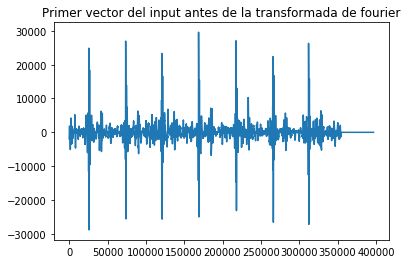

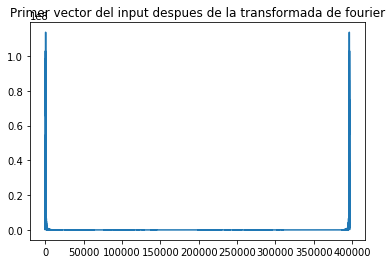

In [11]:
#Antes de aplica transformada de fourier
pl.plot(x[0])
pl.title("Primer vector del input antes de la transformada de fourier")
pl.show()

#Transformada de fourier
x_fourier = np.abs(np.fft.fft(x))
pl.plot(x_fourier[0])
pl.title("Primer vector del input despues de la transformada de fourier")
pl.show()

+ Con la transformada de fourier se consigue que cada vector del input se "normalize", es decir, todos los vectores de entradas tienen el mismo rango de datos.

> g) Para seguir con el pre-procesamiento realice un muestreo representativo de los datos a través de una técnica de muestreo especializada en secuencias ¿En qué beneficia este paso? ¿Cómo podrı́a determinar si el muestro es representativo?

In [12]:
from scipy import signal
x_resampled = []
for i in range(x_fourier.shape[0]):
    sequence = x_fourier[i,:].copy()
    resampled_sequence = signal.resample(sequence, 100000)
    x_resampled.append(resampled_sequence)
x_resampled = np.array(x_resampled)
x_resampled.shape

/Users/marcelacamilaosoriofarias/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/Users/marcelacamilaosoriofarias/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/Users/marcelacamilaosoriofarias/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` 

(124, 100000)

> h) Debido a que no hay conjunto de pruebas, y que es necesario para evaluar la calidad **final** del modelo, genérelo a través de la técnica *hold-out*

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_resampled, y, test_size=0.25, random_state=42)
print("Conjunto de entrada para entrenamiento",X_train.shape)
print("Conjunto de entrada para testear",X_test.shape)
print("Conjunto de salida para entrenamiento",y_train.shape)
print("Conjunto de salida para testear",y_test.shape)

Conjunto de entrada para entrenamiento (93, 100000)
Conjunto de entrada para testear (31, 100000)
Conjunto de salida para entrenamiento (93,)
Conjunto de salida para testear (31,)


> i) Realice un proceso de estándarizar los datos para ser trabajados adecuadamente. Recuerde que solo se debe ajustar (calcular media y desviación estándar) con el conjunto de entrenamiento.

In [14]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=True, with_std=True)
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

>j) Realice una reducción de dimensionalidad a través de la técnica PCA, para representar los datos en  d=2  dimensiones. Recuerde que solo se debe ajustar (encontrar las componentes principales) con el conjunto de entrenamiento. Visualice apropiadamente la proyección en 2 dimensiones.

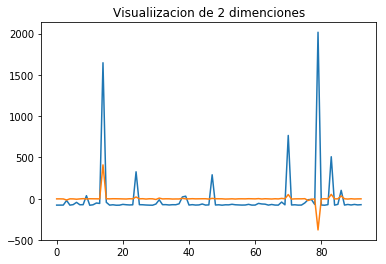

In [16]:
from sklearn.decomposition import PCA
d=2
pca_model = PCA(n_components=d)
pca_model.fit(X_train)
X_pca_train = pca_model.transform(X_train)
X_pca_test = pca_model.transform(X_test)
#visualizacion 

pl.plot(X_pca_train)
pl.title("Visualiizacion de 2 dimenciones")
pl.show()

> k) Entrene un modelo de Regresión Logı́stica variando el parámetro de regularización $C$ construyendo un gráfico resumen del error en función de este hiper-parámetro. Además entrene un Perceptrón, variando el hiper-parámetro de regularización $\alpha$ en el rango inverso que para la Regresión Logı́stica ¿Por qué? Contruya el mismo gráfico resumen, en función de $C$ o $\alpha$. Compare y comente lo observado.

In [17]:
Cs = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alphas = [1/c for c in Cs]

from sklearn.linear_model import Perceptron,LogisticRegression

#Regresion logistica
Aceptacion=[]
for c in Cs:
    model = LogisticRegression(penalty='l2', C=c,max_iter=200) #C es el valor a modificar
    model.fit (X_train, y_train) #Entrenamiento
    y_pred = model.predict(X_test)
    Aceptacion.append(model.score(X_test, y_test))
    print('Exactitud del modelo regresión logística con C =',c ,'es :', model.score(X_test, y_test))


Exactitud del modelo regresión logística con C = 0.0001 es : 0.6451612903225806
Exactitud del modelo regresión logística con C = 0.001 es : 0.6774193548387096
Exactitud del modelo regresión logística con C = 0.01 es : 0.6774193548387096
Exactitud del modelo regresión logística con C = 0.1 es : 0.6129032258064516
Exactitud del modelo regresión logística con C = 1 es : 0.6451612903225806
Exactitud del modelo regresión logística con C = 10 es : 0.6774193548387096
Exactitud del modelo regresión logística con C = 100 es : 0.6774193548387096
Exactitud del modelo regresión logística con C = 1000 es : 0.7096774193548387
Exactitud del modelo regresión logística con C = 10000 es : 0.7096774193548387


Regresión Logística


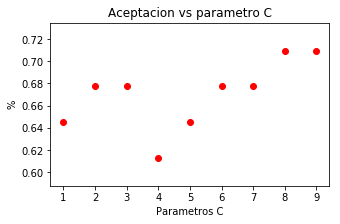

In [19]:
print("Regresión Logística")
import matplotlib.pyplot as plt 
parametros=[1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(5, 3))
plt.scatter(parametros,Aceptacion, c='red')
plt.title('Aceptacion vs parametro C')
plt.xlabel('Parametros C')
plt.ylabel('%')
plt.show()

In [20]:
#Perceptron
Aceptacion=[]
for a in alphas:
    model2 = Perceptron(penalty='l2', alpha=a, max_iter=200) #alpha es el valor a modificar
    model2.fit (X_train, y_train) #Entrenamiento
    y_pred = model2.predict(X_test)
    Aceptacion.append(model2.score(X_test, y_test))
    print('Exactitud Perceptron con alpha =',a ,'es :', model2.score(X_test, y_test))

Exactitud Perceptron con alpha = 10000.0 es : 0.4838709677419355
Exactitud Perceptron con alpha = 1000.0 es : 0.4838709677419355
Exactitud Perceptron con alpha = 100.0 es : 0.4838709677419355
Exactitud Perceptron con alpha = 10.0 es : 0.4838709677419355
Exactitud Perceptron con alpha = 1.0 es : 0.4838709677419355
Exactitud Perceptron con alpha = 0.1 es : 0.6129032258064516
Exactitud Perceptron con alpha = 0.01 es : 0.45161290322580644
Exactitud Perceptron con alpha = 0.001 es : 0.5806451612903226
Exactitud Perceptron con alpha = 0.0001 es : 0.6451612903225806


Perceptron


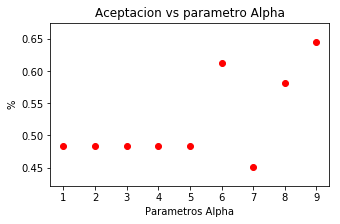

In [22]:
print("Perceptron")
import matplotlib.pyplot as plt 
parametros=[1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(5, 3))
plt.scatter(parametros,Aceptacion, c='red')
plt.title('Aceptacion vs parametro Alpha')
plt.xlabel('Parametros Alpha')
plt.ylabel('%')
plt.show()

> l) Genere otra representación de los datos a través de la técnica de reducción de dimensionalidad **ICA**, con dimensionalidad $d = 2$. Recuerde que sólo se debe ajustar con el conjunto de entrenamiento, si se muestra un *warning* explique el porqué. Visualice apropiadamente la proyección en 2 dimensiones. Vuelva a realizar el item k) pero para esta nueva representación.

In [23]:
from sklearn.decomposition import FastICA
d=2
ica_model = FastICA(n_components=d)
ica_model.fit(X_train)
X_ica_train = ica_model.transform(X_train)
X_ica_test = ica_model.transform(X_test)

> m) Experimente con diferentes dimensiones $d$ para la proyección de PCA e ICA con el propósito de obtener un modelo con menor error. Construya una tabla o gráfico resumen de los errores o *accuracy*, comente.

+ Es utiliza el modelo de Regresión Logística, debido a que obtubo mejores resultados.
+ El parametro C eligido es 100

In [24]:
from sklearn.decomposition import FastICA
d=2
acep1=[]
print("Usando reduccion de dimensionalidad ICA")
while d <22: #Pruebas con 20 dimeciones diferentes
    ica_model = FastICA(n_components=d)
    ica_model.fit(X_train)
    X_ica_train = ica_model.transform(X_train)
    X_ica_test = ica_model.transform(X_test)
    d=d+1
    model = LogisticRegression(penalty='l2', C=100,max_iter=200)
    model.fit (X_ica_train, y_train) #Entrenamiento
    y_pred = model.predict(X_ica_test)
    acep1.append(model.score(X_ica_test, y_test))
    
from sklearn.decomposition import PCA
d=2
acep2=[]
print("Usando reduccion de dimensionalidad PCA")
while d<22:
    pca_model = PCA(n_components=d)
    pca_model.fit(X_train)
    X_pca_train = pca_model.transform(X_train)
    X_pca_test = pca_model.transform(X_test)
    d=d+1
    model = LogisticRegression(penalty='l2', C=100,max_iter=200)
    model.fit (X_pca_train, y_train) #Entrenamiento
    y_pred = model.predict(X_pca_test)
    acep2.append(model.score(X_pca_test, y_test))

Usando reduccion de dimensionalidad ICA
Usando reduccion de dimensionalidad PCA


In [25]:
#Creacion de tabla resumen
dim=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
resumen=pd.DataFrame({
    "Dimenciones" : dim ,
    "ICA" : acep1,
    "PCA" : acep2
})
print(resumen)

    Dimenciones       ICA       PCA
0             1  0.516129  0.451613
1             2  0.516129  0.645161
2             3  0.516129  0.580645
3             4  0.516129  0.677419
4             5  0.516129  0.677419
5             6  0.548387  0.677419
6             7  0.677419  0.741935
7             8  0.677419  0.741935
8             9  0.645161  0.741935
9            10  0.677419  0.709677
10           11  0.645161  0.709677
11           12  0.645161  0.709677
12           13  0.677419  0.709677
13           14  0.677419  0.677419
14           15  0.677419  0.709677
15           16  0.677419  0.709677
16           17  0.612903  0.677419
17           18  0.612903  0.645161
18           19  0.645161  0.645161
19           20  0.645161  0.645161


> n) Realice otra reducción de dimensionalidad ahora a través de la técnica **LDA**, para representar los datos en $d = 2$ dimensiones. Recuerde que sólo se debe ajustar con el conjunto de entrenamiento, si se muestra un *warning* explique el porqué. Visualice apropiadamente la proyección en 2 dimensiones.

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
d=2
lda_model = LDA(n_components=d)
lda_model.fit(X_train,y_train)
X_lda_train = lda_model.transform(X_train)
X_lda_test = lda_model.transform(X_test)

/Users/marcelacamilaosoriofarias/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


> o) Con el propósito de encontrar el mejor modelo vuelva a realizar el item k) en el nuevo espacio generado por la representación según las $d$ dimensiones de la proyección LDA. Esta nueva representación ¿mejora o empeora el desempeño? Explique.

In [27]:
#Regresion logistica
print("Regresión logística \n")
for c in Cs:
    model = LogisticRegression(penalty='l2', C=c,max_iter=200) #C es el valor a modificar
    model.fit (X_lda_train, y_train) #Entrenamiento
    y_pred = model.predict(X_lda_test)
    print('Exactitud del modelo regresión logística con C =',c ,'es :', model.score(X_lda_test, y_test))

#Perceptron
print("\n Perceptron \n")
for a in alphas:
    model2 = Perceptron(penalty='l2', alpha=a, max_iter=200) #alpha es el valor a modificar
    model2.fit (X_lda_train, y_train) #Entrenamiento
    y_pred = model2.predict(X_lda_test)
    print('Exactitud Perceptron con alpha =',a ,'es :', model2.score(X_lda_test, y_test))

Regresión logística 

Exactitud del modelo regresión logística con C = 0.0001 es : 0.5806451612903226
Exactitud del modelo regresión logística con C = 0.001 es : 0.5806451612903226
Exactitud del modelo regresión logística con C = 0.01 es : 0.6451612903225806
Exactitud del modelo regresión logística con C = 0.1 es : 0.6451612903225806
Exactitud del modelo regresión logística con C = 1 es : 0.5806451612903226
Exactitud del modelo regresión logística con C = 10 es : 0.5483870967741935
Exactitud del modelo regresión logística con C = 100 es : 0.6129032258064516
Exactitud del modelo regresión logística con C = 1000 es : 0.5161290322580645
Exactitud del modelo regresión logística con C = 10000 es : 0.5161290322580645

 Perceptron 

Exactitud Perceptron con alpha = 10000.0 es : 0.3870967741935484
Exactitud Perceptron con alpha = 1000.0 es : 0.3870967741935484
Exactitud Perceptron con alpha = 100.0 es : 0.3870967741935484
Exactitud Perceptron con alpha = 10.0 es : 0.3870967741935484
Exactitud 

> p) Intente mejorar el desempeño de los algoritmos ya entrenados. Diseñe ahora sus propias caracterı́sticas (*feature crafting*) a partir de los datos brutos (secuencia de amplitudes), puede inspirarse en otros trabajos [[6]](#refs), [[7]](#refs)  si desea.

<a id="tercero"></a>
## 3. Análisis de emociones en *tweets*

El análisis de emociones o sentimientos se refiere al proceso de extraer información acerca de la actitud que una persona (o grupo de ellas) manifiesta, en un determinado medio o formato digital, con respecto a un tópico o contexto de comunicación. Uno de los casos más estudiados corresponde a determinar la polaridad de un trozo de texto, es decir, clasificar una determinada evaluación escrita (review ), en que una persona manifiesta una opinión, como positiva, negativa o neutral. Esto también ha sido extendido a otros medios, como lo es analizar la polaridad de textos en redes sociales.

<img src="https://image.flaticon.com/sprites/new_packs/132222-color-emotions-assets.png" width="40%" />



Para esta actividad se trabajará con un datasets de tweets ofrecidos por CrowdFlower[[8]](#refs). Cada *tweet* está
asociado a una emoción en particular, donde el conjunto de emociones se trabajarán como mutuamente excluyentes, siendo un problema de múltiples clases.

Los datos pueden ser descargados ejecutando el siguiente código en sistema Unix:
```
wget https://www.crowdflower.com/wp-content/uploads/2016/07/text_emotion.csv
```

Para aumentar la eficacia de las caracterı́sticas extraı́das es conveniente ejecutar algunas técnicas de pre-procesamiento básicas.

> a) Construya un dataframe con los datos a analizar. Determine cuántas clases existen, cuántos registros por clase y describa el dataset.

In [2]:
df = pd.read_csv('./emotionanalysis/text_emotion.csv')

print (df.head())

     tweet_id   sentiment       author  \
0  1956967341       empty   xoshayzers   
1  1956967666     sadness    wannamama   
2  1956967696     sadness    coolfunky   
3  1956967789  enthusiasm  czareaquino   
4  1956968416     neutral    xkilljoyx   

                                             content  
0  @tiffanylue i know  i was listenin to bad habi...  
1  Layin n bed with a headache  ughhhh...waitin o...  
2                Funeral ceremony...gloomy friday...  
3               wants to hang out with friends SOON!  
4  @dannycastillo We want to trade with someone w...  


El dataset cuenta con cuatro columnas:

- tweet_id: Que representa el identificador del tweet.
- sentiment: La emoción a la cual están relacionados los tweets.
- author: el autor del tweet, indicando su nombre de usuario.
- content: el contenido del tweet.

In [3]:
print ("Existen ",df.sentiment.value_counts().shape[0], "clases de sentimientos\n")

print (df.sentiment.value_counts())

Existen  13 clases de sentimientos

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64


> b) Construya un conjunto de entrenamiento y otro de pruebas, a través de una máscara aleatoria, para verificar los resultados de los algoritmos. Genere un conjunto de validación si estima conveniente.

In [4]:
np.random.seed(70)

In [6]:
msk = np.random.rand(len(df)) < 0.8
df_train = df[msk]
df_test = df[~msk]
df_train.shape,df_test.shape

((31978, 4), (8022, 4))

> c) Construya las representaciones de los datos con los que trabajará, ya sea para las entradas de los modelos como para las salidas. Recuerde que tendrá que codificar las distintas clases como valores numéricos enteros. 

In [7]:
df_train.replace({'sentiment': {"neutral": 0, "worry": 1, "happiness": 2, "sadness": 3, "love": 4, "surprise": 5, "fun": 6, "relief": 7, "hate": 8, "empty": 9, "enthusiasm": 10, "boredom": 11, "anger": 12}},  inplace = True)
df_train = df_train.drop(["tweet_id","author"],axis=1)

#df_test  = pd.get_dummies(df_test, columns=["sentiment"]) #column to categorical
df_test.replace({'sentiment': {"neutral": 0, "worry": 1, "happiness": 2, "sadness": 3, "love": 4, "surprise": 5, "fun": 6, "relief": 7, "hate": 8, "empty": 9, "enthusiasm": 10, "boredom": 11, "anger": 12}},  inplace = True)
df_test = df_test.drop(["tweet_id","author"],axis=1)

tweet_train = df_train.content
sentiment_train = df_train.sentiment

tweet_test = df_test.content
sentiment_test = df_test.sentiment

C:\Users\Jorge\Anaconda3\lib\site-packages\pandas\core\generic.py:5817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [17]:
df_test.shape

(8022, 2)

> d) Entrene y compare al menos 4 de los diferentes clasificadores vistos en clases para clasificación (por ejemplo: Navie Bayes, Multinomial Naive Bayes, LDA, QDA, Regresión logı́stica y Perceptrón). Recuerde que algunos son extendidos por defecto a múltiples clases para detectar emociones en cada *tweet*, sin embargo, otros deben ser extentidos a través de otras técnicas, tal como *One vs One* y *One vs All/Rest*. Muestre tabla o gráfico resumen.

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(tweet_train))

X_train = vectorizer.transform(tweet_train)
X_test = vectorizer.transform(tweet_test)

y_train = np.asarray(sentiment_train.astype(float))
y_test = np.asarray(sentiment_test.astype(float))

In [75]:
from sklearn.linear_model import LogisticRegression
model_LR = LogisticRegression(multi_class= 'ovr' or 'multinomial')
model_LR = model_LR.fit(X_train,y_train)

In [76]:
from sklearn.metrics import mean_absolute_error #measure MAE
print("MAE on train: ",mean_absolute_error(y_train, model_LR.predict(X_train)))
print("MAE on validation: ",mean_absolute_error(y_test, model_LR.predict(X_test)))

MAE on train:  0.8733816999186941
MAE on validation:  2.148342059336824


Multinomial Naive Bayes

In [11]:
from sklearn.naive_bayes import MultinomialNB
model_MNB = MultinomialNB()
model_MNB = model_MNB.fit(X_train,y_train)

In [12]:
print("MAE on train: ",mean_absolute_error(y_train, model_MNB.predict(X_train)))
print("MAE on validation: ",mean_absolute_error(y_test, model_MNB.predict(X_test)))

MAE on train:  1.7110826193007693
MAE on validation:  2.1770132136624283


Perceptrón

In [13]:
from sklearn.linear_model import Perceptron
model_P = Perceptron(tol=1e-3, random_state=0)
model_P = model_P.fit(X_train,y_train)

In [14]:
print("MAE on train: ",mean_absolute_error(y_train, model_P.predict(X_train)))
print("MAE on validation: ",mean_absolute_error(y_test, model_P.predict(X_test)))

MAE on train:  0.47144912127087374
MAE on validation:  2.5538519072550487


In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model_LDA = LDA()
X_train2 = X_train.todense()
model_LDA = model_LDA.fit(X_train2,y_train)

MemoryError: 

> e) Utilice la técnica de ECOC (*Error-Correcting Output-Code*) para extender a multiclases algunos de los clasificadores utilizados en d). Comente lo que hace la técnica y los resultados observados.

In [22]:
from sklearn.multiclass import OutputCodeClassifier
model_OCC = OutputCodeClassifier(Perceptron(tol=1e-3, random_state=0),code_size=2, random_state=0)
model_OCC = model_OCC.fit(X_train,y_train)


TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

> f) Evalúe la métrica de *accuracy* sobre el conjunto de pruebas del mejor clasificador encontrado.  
*Recuerde que puede acudir a otras métricas para tener otras visiones de lo que está haciendo el modelo de aprendizaje*

In [78]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, model_LR.predict(X_train))
accuracy_score(y_test, model_LR.predict(X_test))

0.35577162802293694

> g) Intente mejorar su resultado considerablemente a través de alguna mejora novedosa. Se espera que supere el 35% de *accuracy*.

<div class="alert alert-warning"> Una opción es cambiar considerablemente la representación de los textos, ya sea con Tf-Idf, word2vec[[9]](#refs) , doc2vec[[10]](#refs) , otros. </div>

<div class="alert alert-warning"> Otra opción es hacer una clasificación por grupos, es decir, agrupar emociones para ir distinguiendo y bajar la granulidad de la clasificación. Como una clasificación jerárquica en modo árbol.</div>

In [ ]:
#HTML decoding
from bs4 import BeautifulSoup
for i in range(len(df.content)):
    df.content[i] = BeautifulSoup(df.content[i], 'lxml')

C:\Users\Jorge\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [ ]:
# ‘@’mention
import re
for i in range(len(df.content)):
    re.sub(r'@[A-Za-z0-9]+','',df.content[i])

In [ ]:
re.sub('https?://[A-Za-z0-9./]+','',df.text[0])

In [ ]:
re.sub("[^a-zA-Z]", " ", df.text[175])

In [37]:
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
import re
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

clean_train = []
for t in tweet_train:
    clean_train.append(tweet_cleaner(t))
print (clean_train)

clean_test = []
for t in tweet_test:
    clean_test.append(tweet_cleaner(t))
print (clean_train)

['i know i was listenin to bad habit earlier and i started freakin at his part', 'layin n bed with a headache ughhhh waitin on your call', 'funeral ceremony gloomy friday', 'wants to hang out with friends soon', 'i should be sleep but im not thinking about an old friend who i want but he s married now damn he wants me scandalous', 'hmmm is down', 'charlene my love i miss you', 'i m sorry at least it s friday', 'cant fall asleep', 'choked on her retainers', 'ugh i have to beat this stupid song to get to the next rude', 'if u watch the hills in london u will realise what tourture it is because were weeks and weeks late i just watch itonlinelol', 'got the news', 'the storm is here and the electricity is gone', 'so sleepy again and it s not even that late i fail once again', 'lady gaga tweeted about not being impressed by her video leaking just so you know', 'how are you convinced that i have always wanted you what signals did i give off damn i think i just lost another friend', 'no topic 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()
tvec.fit(np.asarray(clean_train))

X_train2 = tvec.transform(clean_train)
X_test2 = tvec.transform(clean_test)

In [83]:
model2_LR = LogisticRegression(multi_class= 'ovr' or 'multinomial')
model2_LR = model2_LR.fit(X_train2,y_train)

In [84]:
print("MAE on train: ",mean_absolute_error(y_train, model2_LR.predict(X_train2)))
print("MAE on validation: ",mean_absolute_error(y_test, model2_LR.predict(X_test2)))

MAE on train:  1.8588717243104635
MAE on validation:  2.148342059336824


In [86]:
print(accuracy_score(y_train, model2_LR.predict(X_train2)))
accuracy_score(y_test, model2_LR.predict(X_test2))

0.49459003064606916


0.35602094240837695